In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import statsmodels as sm

In [2]:
sns.set_context("poster")
sns.set_style("ticks")

In [3]:
df = pd.read_excel("./shelf-life-study-data-for-analytics-challenge_prediction.xlsx")

In [4]:
df.head()

,Study Number,Sample ID,Product Type,Base Ingredient,Process Type,Sample Age (Weeks),Difference From Fresh,Storage Conditions,Packaging Stabilizer Added,Transparent Window in Package,Processing Agent Stability Index,Preservative Added,Moisture (%),Residual Oxygen (%),Hexanal (ppm),Prediction
0,1310186,1310186-1,D,NaN,C,0.0,0.00,NaN,NaN,NaN,16.2,NaN,NaN,NaN,NaN,NaN
1,1310186,1310186-1,D,NaN,C,10.0,0.00,NaN,NaN,NaN,16.2,NaN,1.56,2.865,0.095,NaN
2,1310186,1310186-1,D,NaN,C,14.0,0.00,NaN,NaN,NaN,16.2,NaN,1.64,2.945,0.100,NaN
3,1310186,1310186-1,D,NaN,C,16.0,3.31,NaN,NaN,NaN,16.0,NaN,1.60,7.130,0.090,NaN
4,1310186,1310186-1,D,NaN,C,18.0,2.65,NaN,NaN,NaN,16.0,NaN,1.70,12.725,0.470,NaN


Study Number int64 int64
1614359    54
1310746    30
1614242    30
1310893    24
1613520    23
           ..
1411253     3
1411014     3
1512712     3
1411032     3
1513115     3
Name: Study Number, Length: 81, dtype: int64
Sample ID object object
1614242-2    15
1614242-1    15
1613469-1    13
1613530-1    13
1310881-1    13
             ..
1513327-1     3
1411032-1     3
1512534-1     3
1512161-1     2
1512161-3     2
Name: Sample ID, Length: 112, dtype: int64
Product Type object object
E    248
H    162
F     87
A     71
B     56
C     48
G     40
D     26
I     11
Name: Product Type, dtype: int64
Base Ingredient object object
A       259
C       248
NONE    109
D        83
B        25
F        14
E        11
Name: Base Ingredient, dtype: int64
Process Type object object
C    534
A    167
B     48
Name: Process Type, dtype: int64
Sample Age (Weeks) float64 float64
0.0     112
16.0     55
12.0     55
26.0     46
20.0     46
22.0     44
24.0     44
14.0     40
8.0      40
10.0     35


/home/shivangi/anaconda2/envs/python3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:316: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.hist(values, bins=bins, **kwds)


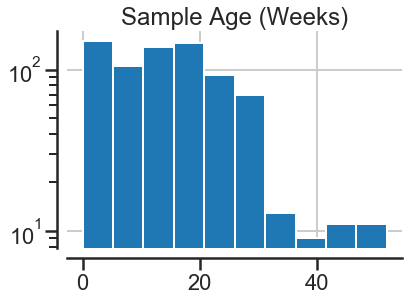

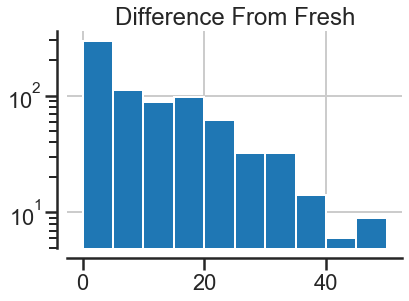

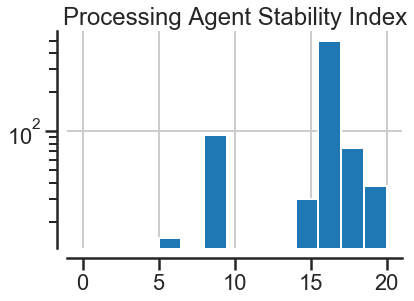

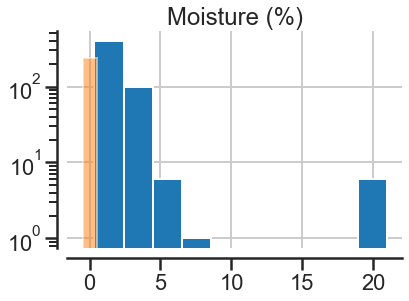

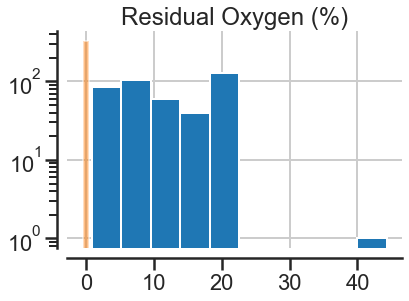

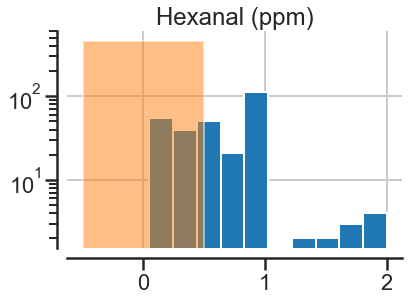

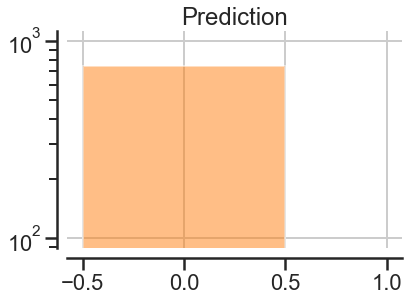

In [5]:
for c in df.columns:
    df_t = df[c].fillna("NONE")
    print(c, df[c].dtype, df_t.dtype)
    print(df_t.value_counts())
    if df[c].dtype == "float64":
        fig, ax = plt.subplots(1,1)
        ax = df.loc[~df[c].isnull(), c].hist(log=True, ax=ax)
        ax = df.loc[df[c].isnull(), c].fillna(0.0).hist(bins=1, log=True, alpha=0.5, ax=ax)
        ax.set_title(c)
        sns.despine(offset=10)

## Product wise splits

In [6]:
df.columns

Index(['Study Number', 'Sample ID', 'Product Type', 'Base Ingredient',
       'Process Type', 'Sample Age (Weeks)', 'Difference From Fresh',
       'Storage Conditions', 'Packaging Stabilizer Added',
       'Transparent Window in Package', 'Processing Agent Stability Index',
       'Preservative Added', 'Moisture (%)', 'Residual Oxygen (%)',
       'Hexanal (ppm)', 'Prediction'],
      dtype='object')

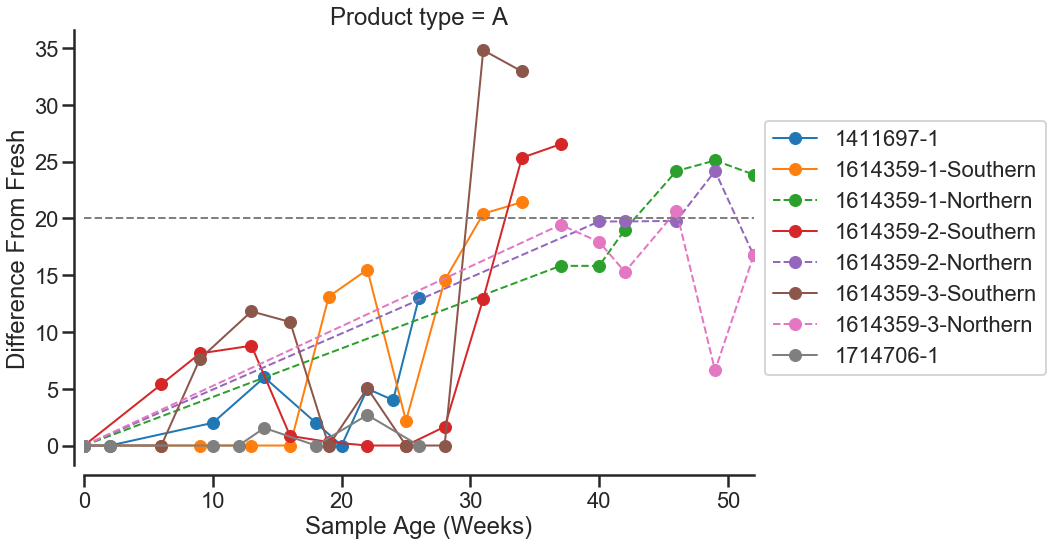

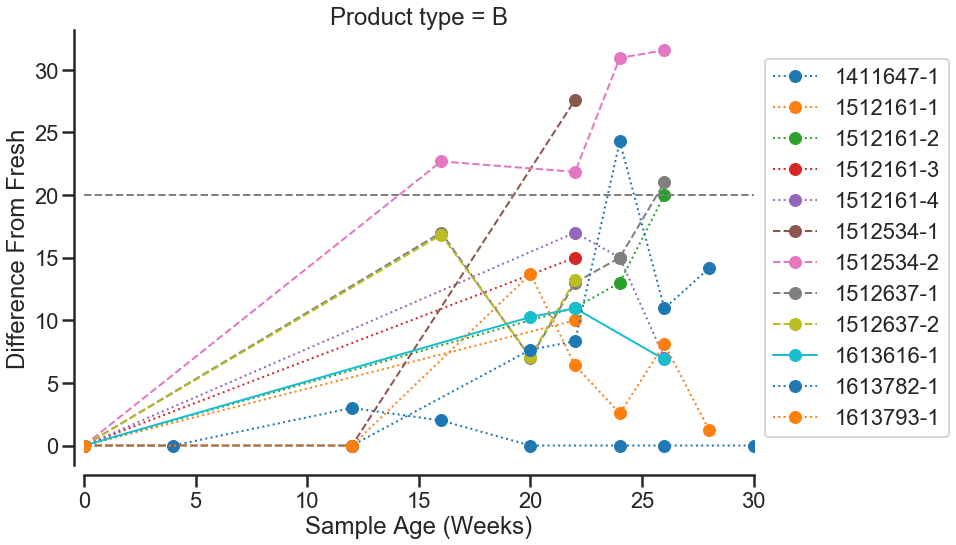

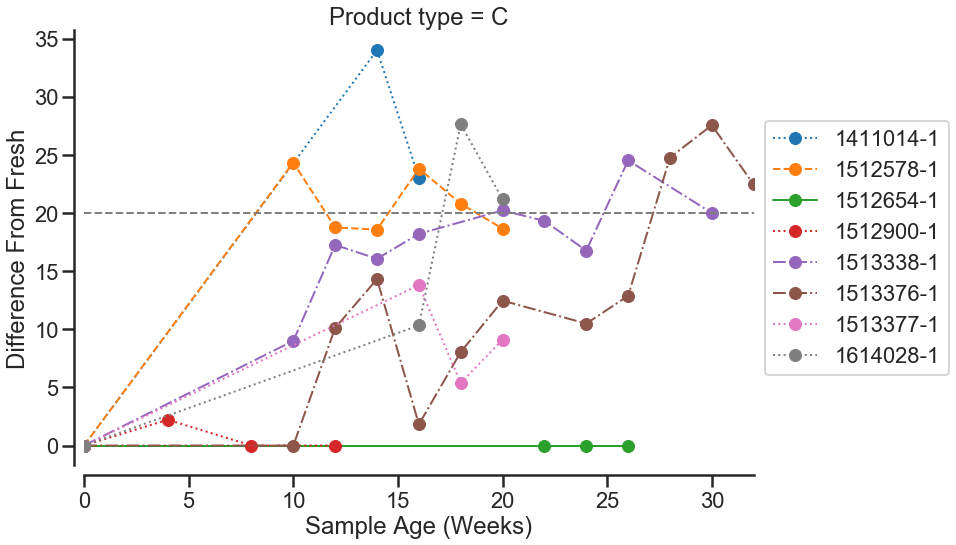

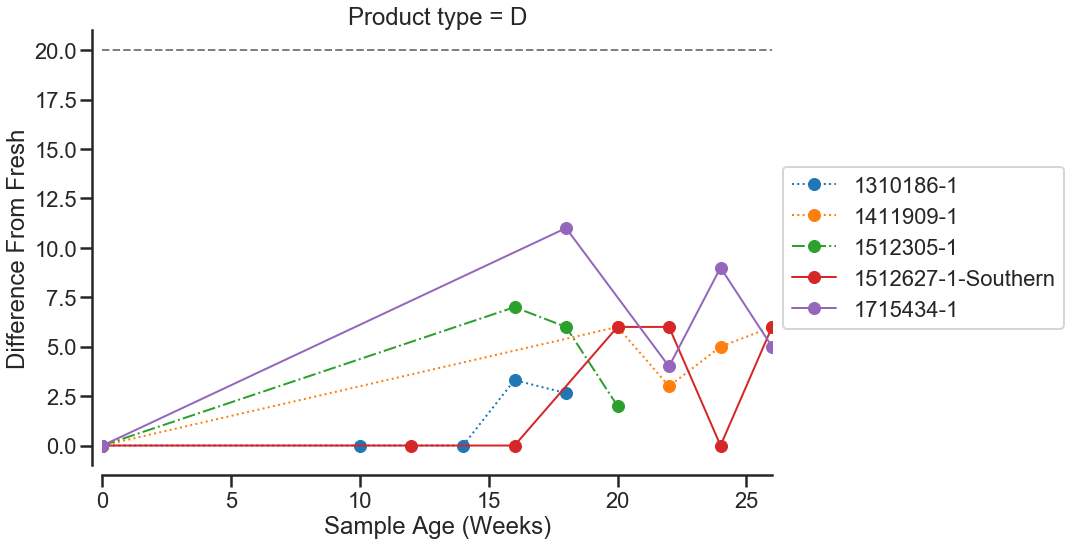

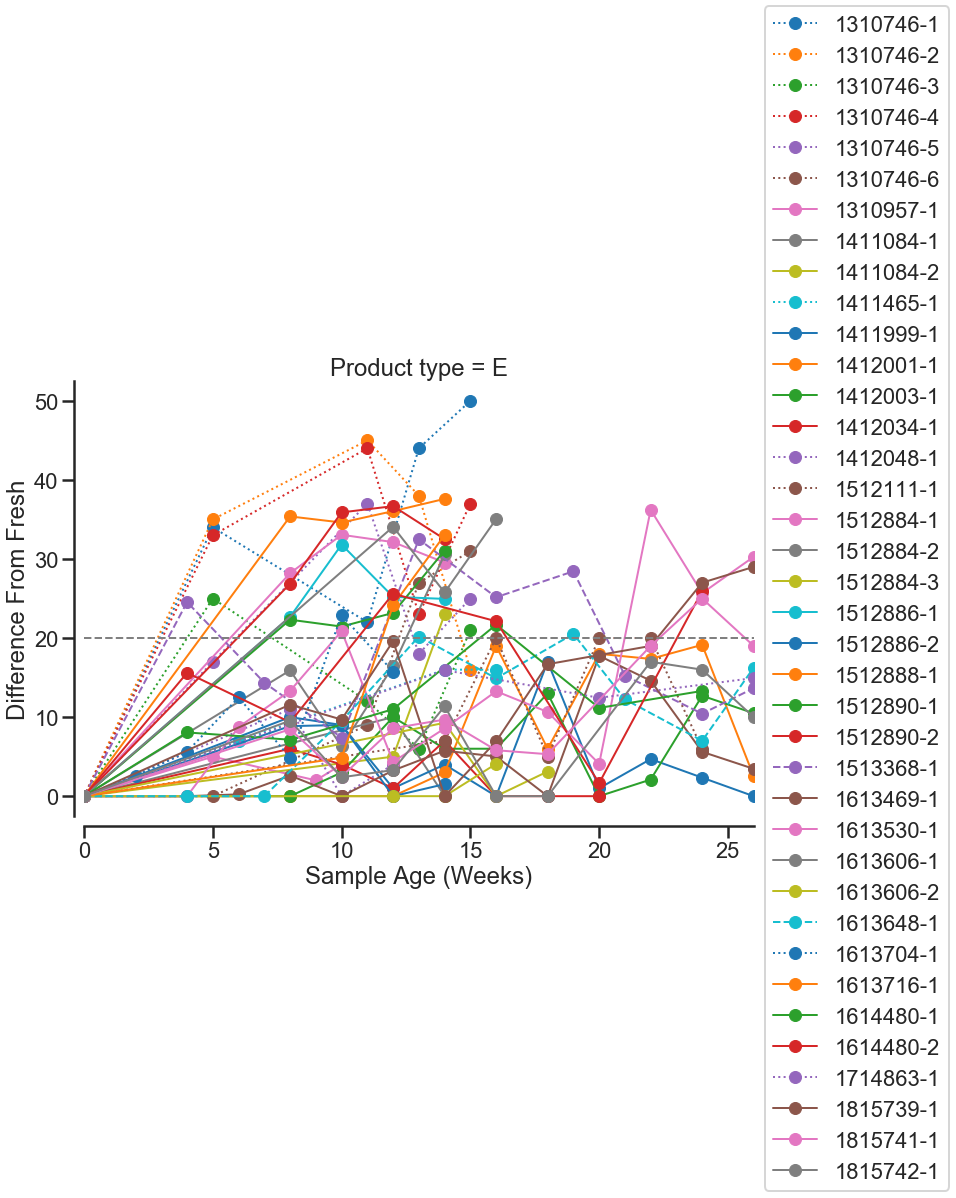

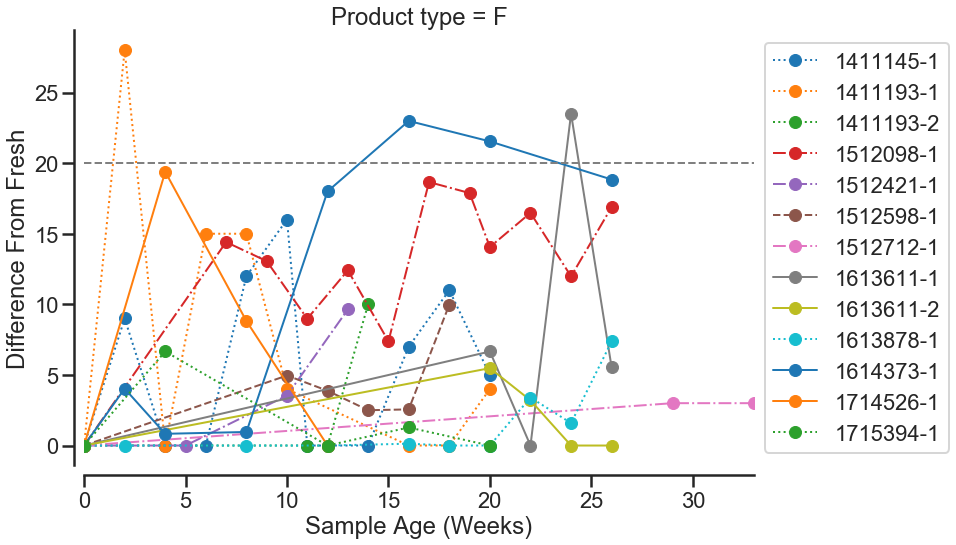

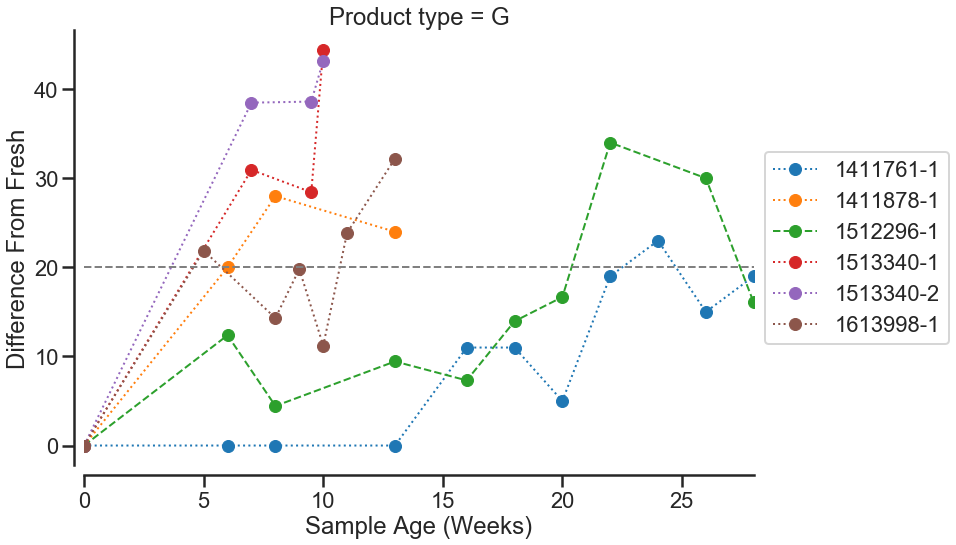

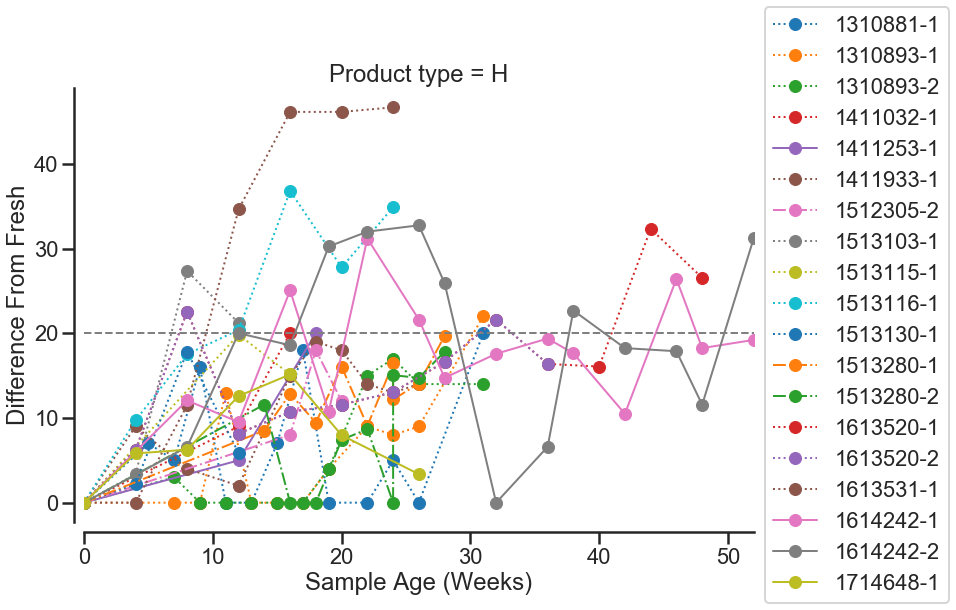

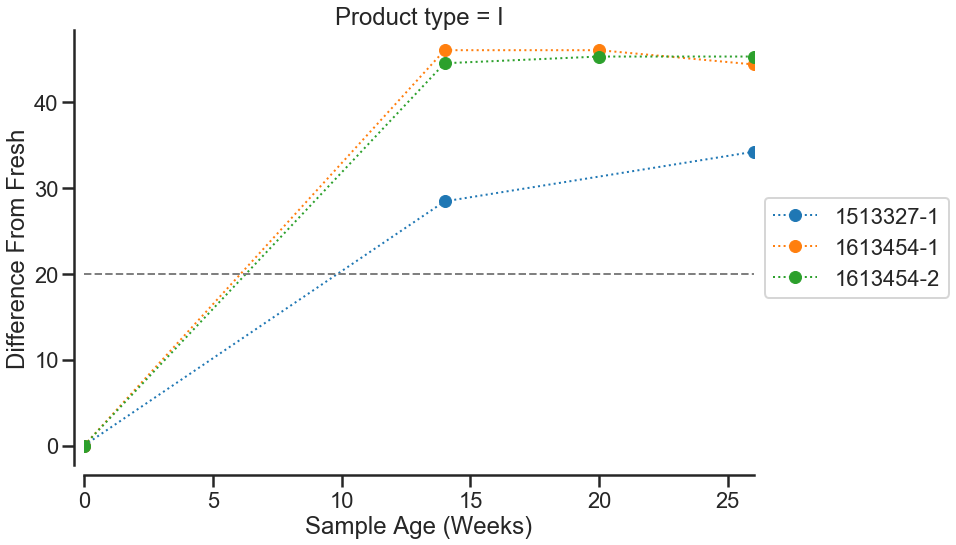

In [7]:
linestyles = {
    "Warm Climate": "-",
    "NONE": ":",
    "Cold Climate": "--",
    "High Temperature and Humidity": "-."
}
for product_type in sorted(df['Product Type'].unique()):
    fig, ax = plt.subplots(1,1, figsize=(12, 8))
    for sample_id in df.loc[df["Product Type"] == product_type, "Sample ID"].unique():
        df_t = df[df["Sample ID"] == sample_id]
        linestyle_keys = df_t["Storage Conditions"].fillna("NONE").unique()
        assert len(linestyle_keys) == 1, f"Many process types: {linestyle_keys}"
        df[df["Sample ID"] == sample_id].plot(
            x="Sample Age (Weeks)", y="Difference From Fresh", kind="line", ax=ax, label=sample_id,
            lw=2, linestyle=linestyles[linestyle_keys[0]], marker="o"
        )
    plt.axhline(y=20, lw=2, linestyle="--", color="0.5")
    plt.ylabel("Difference From Fresh")
    plt.title(f"Product type = {product_type}")
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    sns.despine(offset=10)

In [8]:
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression

In [9]:
def plot_isotonic(x, y, **plot_kwargs):
    model = IsotonicRegression(y_min=0).fit(x, y)
    x_pred = np.arange(x.min(), x.max(), 0.1)
    y_pred = model.predict(x_pred)
    plt.plot(x_pred, y_pred, **plot_kwargs)
       

In [10]:
def get_least_x_above_threashold(ax):
    lines = ax.get_children()[2]
    critical_point = [dict(x=x, y=y) for x,y in lines.get_xydata() if y > 20][0]
    return critical_point

def get_critical_x_for_all_sample(g, sample_clusters):
    critical_points = {
        cluster_id: get_least_x_above_threashold(ax)
        for cluster_id, ax in zip(g.col_names, g.axes.flatten())
    }
    sample_critical_points = {
        sample_id: dict(cluster_id=cluster_id, **critical_points[cluster_id])
        for sample_id, cluster_id in sample_clusters.items()
    }
    return sample_critical_points
    

def plot_product(product_type, sample_clusters, regression_order=1):
    sns.set_context("poster", font_scale=1, rc={"lines.linewidth": 2.5})
    sns.set_style("ticks")
    g = sns.FacetGrid(
        data=df[df["Product Type"] == product_type].assign(
            sample_cluster=lambda x: x["Sample ID"].map(sample_clusters)
        ),
        col="sample_cluster", 
        #hue="Sample ID",
        col_wrap=3,
        height=5,
        aspect=1.5,
        xlim=[0,150],
        ylim=[0,40]
    )

    """g.map(
        plt.plot,
        "Sample Age (Weeks)", 
        "Difference From Fresh", 
        lw=2,
        marker="+",
        linestyle="None"
    )"""

    g.map(
        sns.regplot,
        "Sample Age (Weeks)", 
        "Difference From Fresh",
        order=regression_order,
        marker="+"
    )

    g.map(
        plt.axhline,
        y=20,
        lw=1, linestyle="--", color="0.5"
    )

    g.map(
        plot_isotonic,
        "Sample Age (Weeks)", 
        "Difference From Fresh", 
        lw=2,
        linestyle="--"
    )
    
    sample_critical_points = get_critical_x_for_all_sample(g, sample_clusters)
    df_sample_critical_points = pd.DataFrame(sample_critical_points).T
    display(df_sample_critical_points)
    return sample_critical_points, g
    

## Instructions for creating the plots based on product clusters

* Update the sample_clusters with the "Sample ID" and the cluster_id. 
* You can assign any cluster ID as you like. 
* I have used the convention of product_type and then a number starting from 0 to denote clusters
* Create a new cell for each product type and assign the variable `product_type` for the product type you want to investigate. 
* Run `sample_critical_points, g = plot_product(product_type, sample_clusters)`, this will generate the plot and will create a table for critical points (the smallest x for which the y is greater than the threshhold *(20)*). 
* The default regression order is `regression_order=1` you can pass a higher number to fit higher order regression models.


In [11]:
sample_clusters = {
    '1411697-1': "A1", 
    '1614359-1-Southern': "A1", 
    '1614359-1-Northern': "A0",
    '1614359-2-Southern': "A1", 
    '1614359-2-Northern': "A0", 
    '1614359-3-Southern': "A1",
    '1614359-3-Northern': "A0",
    '1714706-1': "A1"
}

,cluster_id,x,y
1411697-1,A1,43.9394,20.5413
1614359-1-Southern,A1,43.9394,20.5413
1614359-1-Northern,A0,48.4848,20.1876
1614359-2-Southern,A1,43.9394,20.5413
1614359-2-Northern,A0,48.4848,20.1876
1614359-3-Southern,A1,43.9394,20.5413
1614359-3-Northern,A0,48.4848,20.1876
1714706-1,A1,43.9394,20.5413


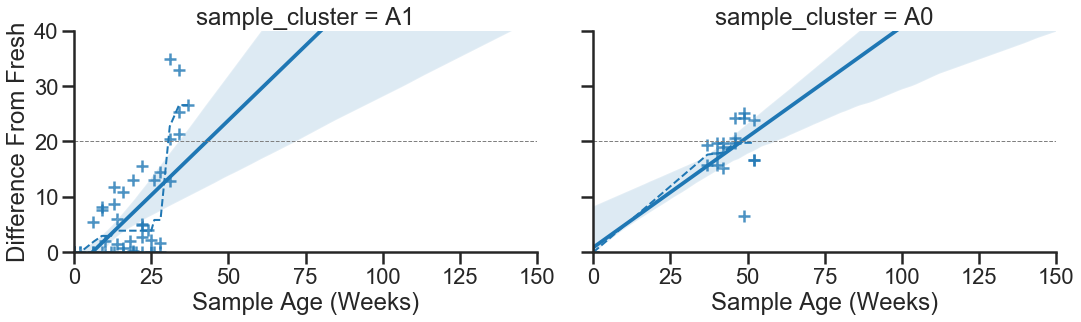

In [12]:
product_type = "A"
sample_critical_points, g = plot_product(product_type, sample_clusters, regression_order=1)

Text(0, 30, '(x=43.94, y=20.54)')

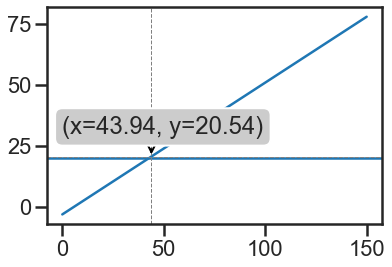

In [13]:
ax = g.axes[0]
lines = ax.get_children()[2]
plt.plot(lines.get_xdata(), lines.get_ydata())
plt.axhline(y=20)
critical_point = [(x,y) for x,y in lines.get_xydata() if y > 20][0]
plt.axhline(y=critical_point[1], lw=1, linestyle="--", color="0.5")
plt.axvline(x=critical_point[0], lw=1, linestyle="--", color="0.5")
offset = 20
arrowprops = dict(
    arrowstyle = "->",
    color="k",
    connectionstyle = "angle,angleA=0,angleB=90,rad=10")
bbox = dict(boxstyle="round", fc="0.8")
plt.annotate(
    f"(x={critical_point[0]:.2f}, y={critical_point[1]:.2f})", 
    critical_point,
    xytext=(0, 30),
    bbox=bbox, arrowprops=arrowprops
)

In [14]:
sample_clusters_I = {
    '1513327-1': "I1", 
    '1613454-1': "I1",
    '1613454-2': "I1"
}

,cluster_id,x,y
1513327-1,I1,9.09091,21.1081
1613454-1,I1,9.09091,21.1081
1613454-2,I1,9.09091,21.1081


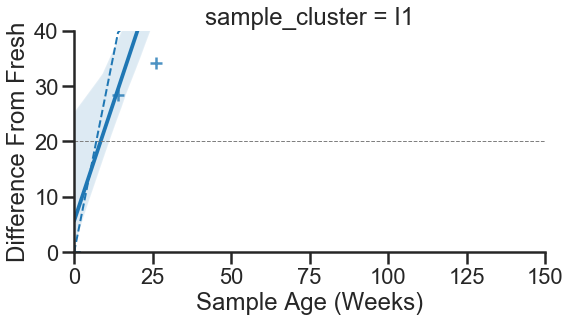

In [15]:
product_type = "I"
sample_critical_points, g = plot_product(product_type, sample_clusters_I, regression_order=1)

Text(0, 30, '(x=9.09, y=21.11)')

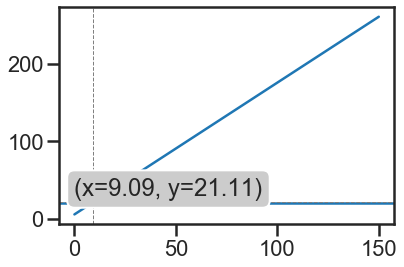

In [16]:
ax = g.axes[0]
lines = ax.get_children()[2]
plt.plot(lines.get_xdata(), lines.get_ydata())
plt.axhline(y=20)
critical_point = [(x,y) for x,y in lines.get_xydata() if y > 20][0]
plt.axhline(y=critical_point[1], lw=1, linestyle="--", color="0.5")
plt.axvline(x=critical_point[0], lw=1, linestyle="--", color="0.5")
offset = 20
arrowprops = dict(
    arrowstyle = "->",
    color="k",
    connectionstyle = "angle,angleA=0,angleB=90,rad=10")
bbox = dict(boxstyle="round", fc="0.8")
plt.annotate(
    f"(x={critical_point[0]:.2f}, y={critical_point[1]:.2f})", 
    critical_point,
    xytext=(0, 30),
    bbox=bbox, arrowprops=arrowprops
)

In [17]:
sample_clusters_G = {
    '1141761-1': "G1", 
    '1512296-1': "G1",
    '1411878-1': "G2",
    '1513340-1': "G2",
    '1513340-2': "G2",
    '1613998-1': "G2"
}

,cluster_id,x,y
1141761-1,G1,22.7273,20.6725
1512296-1,G1,22.7273,20.6725
1411878-1,G2,7.57576,23.1339
1513340-1,G2,7.57576,23.1339
1513340-2,G2,7.57576,23.1339
1613998-1,G2,7.57576,23.1339


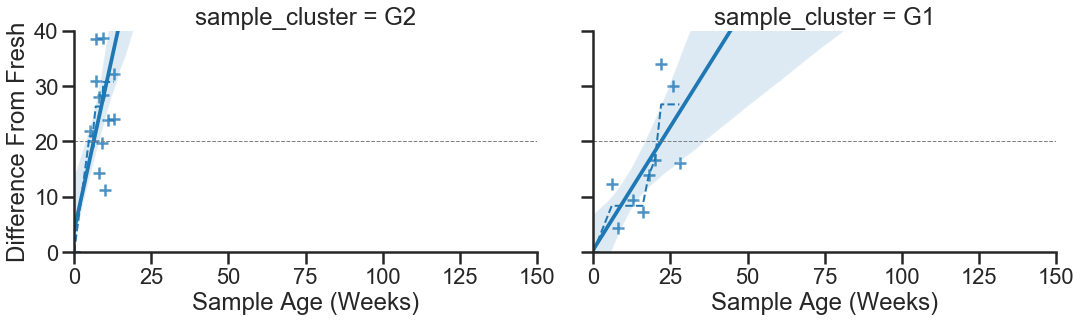

In [18]:
product_type = "G"
sample_critical_points, g = plot_product(product_type, sample_clusters_G, regression_order=1)

In [19]:
sample_clusters_C = {
    '1411014-1': "C1", 
    '1512578-1': "C1",
    '1512900-1': "C2",
    '1513338-1': "C2",
    '1513376-1': "C2",
    '1513377-1': "C2",
    '1614028-1': "C2"
}
#1512654_1 has 0 slope  (warm climate + processing stabilizer added)

,cluster_id,x,y
1411014-1,C1,13.6364,20.154
1512578-1,C1,13.6364,20.154
1512900-1,C2,27.2727,20.5639
1513338-1,C2,27.2727,20.5639
1513376-1,C2,27.2727,20.5639
1513377-1,C2,27.2727,20.5639
1614028-1,C2,27.2727,20.5639


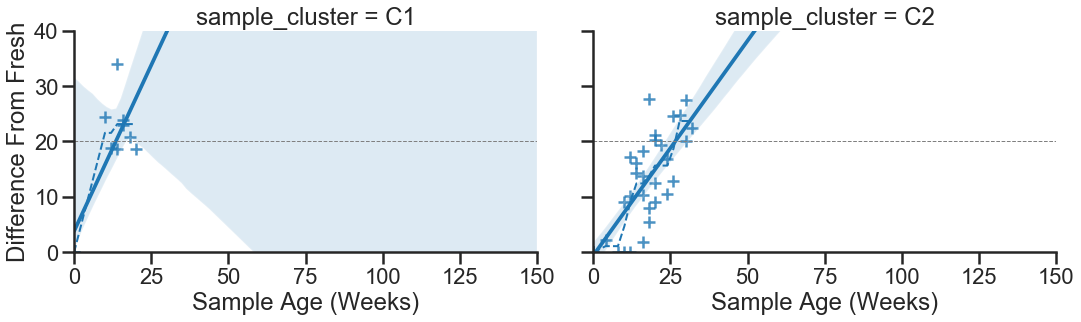

In [20]:
product_type = "C"
sample_critical_points, g = plot_product(product_type, sample_clusters_C, regression_order=1)

In [21]:
sample_clusters_D = {
    '1310186-1': "D1", 
    '1411909-1': "D1",
    '1512305-1': "D1",
    '1512627-1-Southern': "D1",
    '1715434-1': "D1"
}

,cluster_id,x,y
1310186-1,D1,87.8788,20.0418
1411909-1,D1,87.8788,20.0418
1512305-1,D1,87.8788,20.0418
1512627-1-Southern,D1,87.8788,20.0418
1715434-1,D1,87.8788,20.0418


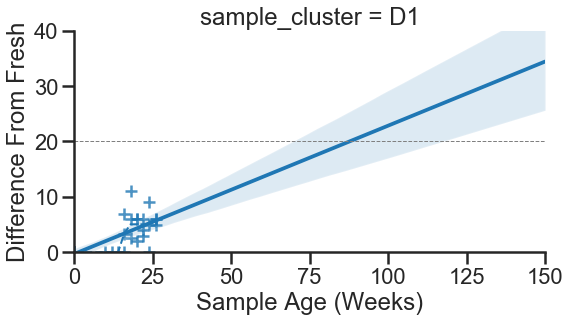

In [22]:
product_type = "D"
sample_critical_points, g = plot_product(product_type, sample_clusters_D, regression_order=1)

In [23]:
sample_clusters_F = {
    '1411193-1': "F1", 
    '1714526-1': "F1",
    '1614373-1': "F1",
    '1411145-1': "F1",
    '1512098-1': "F1",
    '1411193-2': "F2",
    '1512421-1': "F1",
    '1512598-1': "F2",
    '1512712-1': "F2",
    '1613611-1': "F2",
    '1613611-2': "F2",
    '1613878-1': "F2",
    '1715394-1': "F2"
}

,cluster_id,x,y
1411193-1,F1,39.3939,20.4277
1714526-1,F1,39.3939,20.4277
1614373-1,F1,39.3939,20.4277
1411145-1,F1,39.3939,20.4277
1512098-1,F1,39.3939,20.4277
1411193-2,F2,125.758,20.1674
1512421-1,F1,39.3939,20.4277
1512598-1,F2,125.758,20.1674
1512712-1,F2,125.758,20.1674
1613611-1,F2,125.758,20.1674


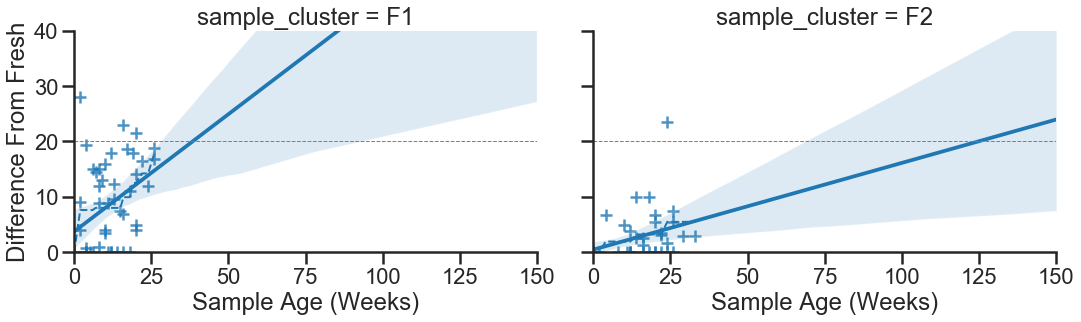

In [24]:
product_type = "F"
sample_critical_points, g = plot_product(product_type, sample_clusters_F, regression_order=1)

In [25]:
sample_clusters_B = { 
    '1411647-1': "B1",
    '1512161-1': "B1",
    '1512161-2': "B1",
    '1512161-3': "B1",
    '1512161-4': "B1",
    '1512534-1': "B1",
    '1512534-2': "B1",
    '1512637-1': "B1",
    '1512637-2': "B1",
    '1613616-1': "B1",
    '1613782-1': "B1",
    '1613793-1': "B1"
}

,cluster_id,x,y
1411647-1,B1,39.3939,20.0506
1512161-1,B1,39.3939,20.0506
1512161-2,B1,39.3939,20.0506
1512161-3,B1,39.3939,20.0506
1512161-4,B1,39.3939,20.0506
1512534-1,B1,39.3939,20.0506
1512534-2,B1,39.3939,20.0506
1512637-1,B1,39.3939,20.0506
1512637-2,B1,39.3939,20.0506
1613616-1,B1,39.3939,20.0506


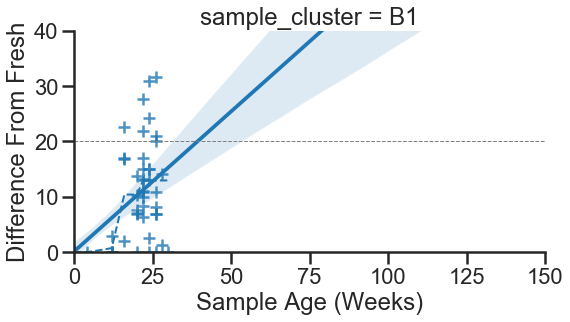

In [29]:
product_type = "B"
sample_critical_points, g = plot_product(product_type, sample_clusters_B, regression_order=1)

In [30]:
sample_clusters_H = { 
    '1310881-1': "H1",
    '1310893-1': "H1",
    '1310893-2': "H1",
    '1411032-1': "H1",
    '1411253-1': "H1",
    '1411933-1': "H1",
    '1512305-2': "H1",
    '1513103-1': "H1",
    '1513115-1': "H1",
    '1513116-1': "H1",
    '1513130-1': "H1",
    '1513280-1': "H1",
    '1513280-2': "H1",
    '1613520-1': "H1",
    '1613520-2': "H1",
    '1613531-1': "H1",
    '1614242-1': "H1",
    '1614242-2': "H1",
    '1714648-1': "H1"
}

,cluster_id,x,y
1310881-1,H1,37.8788,20.331
1310893-1,H1,37.8788,20.331
1310893-2,H1,37.8788,20.331
1411032-1,H1,37.8788,20.331
1411253-1,H1,37.8788,20.331
1411933-1,H1,37.8788,20.331
1512305-2,H1,37.8788,20.331
1513103-1,H1,37.8788,20.331
1513115-1,H1,37.8788,20.331
1513116-1,H1,37.8788,20.331


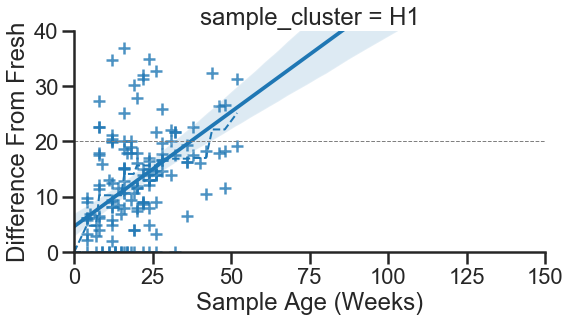

In [31]:
product_type = "H"
sample_critical_points, g = plot_product(product_type, sample_clusters_H, regression_order=1)

In [32]:
sample_clusters_E = { 
    '1310746-1': "E1",
    '1310746-2': "E1",
    '1310746-3': "E1",
    '1310746-4': "E1",
    '1310746-5': "E1",
    '1310746-6': "E1",
    '1310957-1': "E1",
    '1411084-1': "E1",
    '1411084-2': "E1",
    '1411465-1': "E1",
    '1411999-1': "E1",
    '1412001-1': "E1",
    '1412003-1': "E1",
    '1412034-1': "E1",
    '1412048-1': "E1",
    '1512111-1': "E1",
    '1512884-1': "E1",
    '1512884-2': "E1",
    '1512884-3': "E1",
    '1512886-1': "E1",
    '1512886-2': "E1",
    '1512888-1': "E1",
    '1512890-1': "E1",
    '1512890-2': "E1",
    '1513368-1': "E1",
    '1613469-1': "E1",
    '1613530-1': "E1",
    '1613606-1': "E1",
    '1613606-2': "E1",
    '1613648-1': "E1",
    '1613704-1': "E1",
    '1613716-1': "E1",
    '1614480-1': "E1",
    '1614480-2': "E1",
    '1714863-1': "E1",
    '1815739-1': "E1",
    '1815741-1': "E1",
    '1815742-1': "E1"
}

,cluster_id,x,y
1310746-1,E1,28.7879,20.403
1310746-2,E1,28.7879,20.403
1310746-3,E1,28.7879,20.403
1310746-4,E1,28.7879,20.403
1310746-5,E1,28.7879,20.403
1310746-6,E1,28.7879,20.403
1310957-1,E1,28.7879,20.403
1411084-1,E1,28.7879,20.403
1411084-2,E1,28.7879,20.403
1411465-1,E1,28.7879,20.403


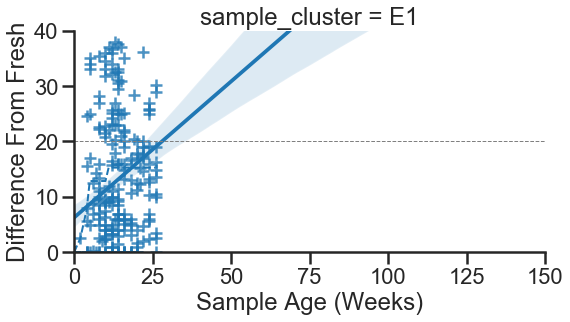

In [33]:
product_type = "E"
sample_critical_points, g = plot_product(product_type, sample_clusters_E, regression_order=1)